## Create Classifiation Models

In this notebook, we create models to classify the popularity of posts in the subreddit.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## load data

df = pd.read_pickle("WSB_week.pkl")
df['score'] = df['score'].astype(float)
df['time_created'] = df['time_created'].astype(float)
df['title_length'] = df['title_length'].astype(float)
df['num_comments'] = df['num_comments'].astype(float)
df['num_top_comments'] = df['num_top_comments'].astype(float)
df['upvote_ratio'] = df['upvote_ratio'].astype(float)
df.head()

,id,title,body,score,time_created,flair,num_comments,title_length,body_length,num_top_comments,upvote_ratio,first_hour_comments,first_30_comments,first_120_comments,first_90_comments
nmk9dk,nmk9dk,amc’s four-day surge slaps short sellers with ...,,36385.0,1.622157e+09,News,2199.0,63.0,0,128.0,0.90,37,18,59,44
nmydzw,nmydzw,"1 million in bb, let's see what happens",,2325.0,1.622210e+09,YOLO,425.0,39.0,0,291.0,0.92,76,34,150,116
nmtcr3,nmtcr3,$bb | technical analysis | the bottom has full...,is it time to pick some juicy berries? 🍇\n\ni ...,1982.0,1.622191e+09,Technical Analysis,438.0,109.0,757,239.0,0.93,9,6,13,12
nmjo2l,nmjo2l,proper 401k weighting for a 26 year old? 99.8%...,,1770.0,1.622155e+09,YOLO,274.0,62.0,0,83.0,0.95,15,10,18,17
nmwjy3,nmwjy3,palantir awarded $111m contract to provide mis...,,1267.0,1.622204e+09,News,179.0,116.0,0,65.0,0.93,13,8,27,20


We make an outputs dataframe, and set a "principal" score, which is the principal axis from the PCA on these 3 features.

In [3]:
outputs = df[['score', 'num_top_comments', 'upvote_ratio']].astype(float)

In [4]:
## normalize the outputs 

outputs["norm_score"] = (outputs.score - outputs.score.mean()) / outputs.score.std()
outputs["norm_comments"] = (outputs.num_top_comments - outputs.num_top_comments.mean()) / outputs.num_top_comments.std()
outputs["norm_ratio"] = (outputs.upvote_ratio - outputs.upvote_ratio.mean()) / outputs.upvote_ratio.std()

outputs_final = outputs[['norm_score', 'norm_comments', 'norm_ratio']]
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(outputs_final)

PCA(n_components=3)

In [5]:
outputs["principal"] = pca.components_[0][0]*outputs.norm_score + pca.components_[0][1]*outputs.norm_comments + pca.components_[0][2]*outputs.norm_ratio 

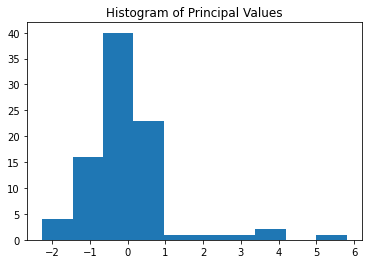

In [6]:
outputs_copy = outputs.copy()
df["principal"] = outputs_copy.principal
plt.hist(df.principal)
plt.title("Histogram of Principal Values")
plt.show()

In [7]:
## check the explained variance of our principal score
print("The explained variances of our principal values are:")
print(pca.explained_variance_ratio_)

The explained variances of our principal values are:
[0.43790725 0.30557538 0.25651737]


In [8]:
## check the correlation of our principal score with other variables

print("The correlation of the principal score with various variables:")
df.corr()['principal'].sort_values()

The correlation of the principal score with various variables:


title_length           0.001149
time_created           0.079461
first_30_comments      0.470774
first_hour_comments    0.527607
first_90_comments      0.540926
num_comments           0.552987
first_120_comments     0.553477
score                  0.601900
upvote_ratio           0.628804
num_top_comments       0.745683
principal              1.000000
Name: principal, dtype: float64

Posts are classified as popular if the principal score is above the 50% quantile.

In [9]:
df['class'] = df['principal'] > df['principal'].quantile(0.5)
df['class'] = df['class'].astype(int)
df['class'].mean()

0.4943820224719101

We first attempt to use the KNN algorithm to classify our posts. The get_acc function is from the "K Nearest Neighbors" lecture, written for the Erdős Institute Cőde Data Science Boot Camp by Matthew Osborne, Ph. D., 2021.

In [10]:
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)


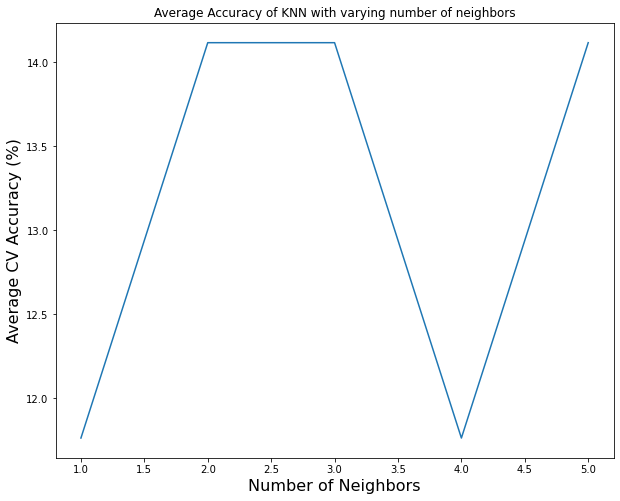

In [11]:
## KNN implementation

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
## define data

kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

max_neighbors = 5

X = df[['first_30_comments','first_hour_comments']].to_numpy()
y = df[['class']].to_numpy()


## Make an empty array to hold your cv accuracies here
accuracy = np.zeros((5,max_neighbors))

for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = 0;
    j = 0
    for i in range (0,max_neighbors):
        knn = KNeighborsClassifier(n_neighbors = i+1)
        knn.fit(X_train,y_train.ravel())
        accuracy[j][i] = get_acc(knn,X_test,y_test.ravel())
        i = i+1
    j = j+1

#Plot how the accuracy changes

plt.figure(figsize=(10,8))

## Plot the number of neighbors on the x
## plot the avg cross validation accuracy on the y
plt.plot(np.linspace(1,max_neighbors,num=max_neighbors),100*np.mean(accuracy,axis=0))

## Use these as your axes labels
plt.xlabel("Number of Neighbors", fontsize=16)
plt.ylabel("Average CV Accuracy (%)", fontsize=16)
plt.title("Average Accuracy of KNN with varying number of neighbors")
plt.show()

The code below allows us to create a random forest classifier (optional).

In [12]:
## from sklearn.ensemble import RandomForestClassifier
## from sklearn.model_selection import train_test_split
## from sklearn.metrics import confusion_matrix

## X_train, X_test, y_train, y_test = train_test_split(X, y, 
##                                                    test_size=0.3, 
##                                                    random_state=6)

## clf = RandomForestClassifier(max_depth = 4, random_state=614)

## clf.fit(X_train,y_train.ravel())

## 100*get_acc(clf,X_test,y_test.ravel())



We now create a decision tree.

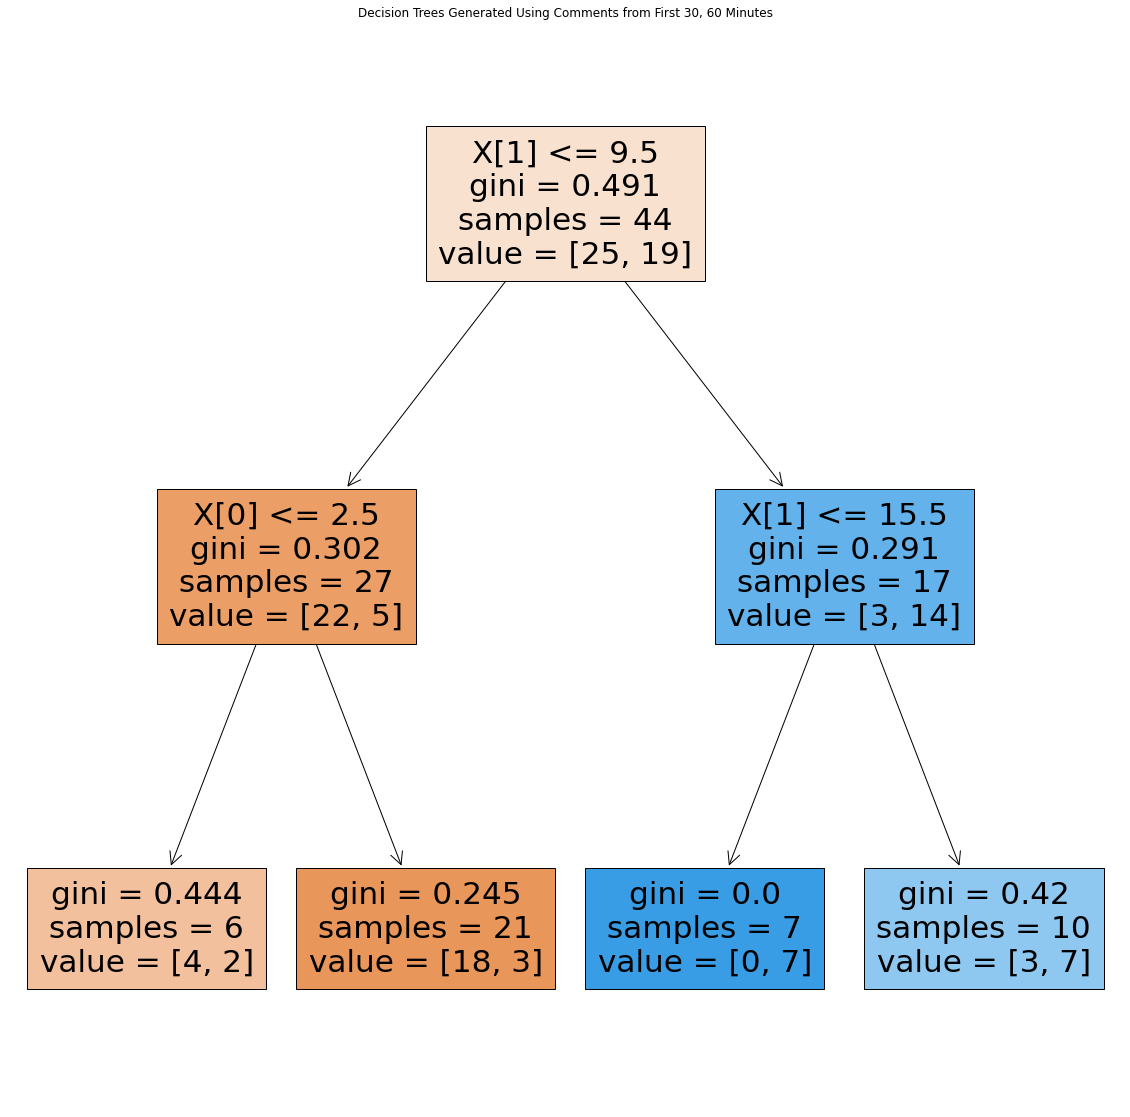

In [13]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

X = df[['first_30_comments','first_hour_comments']].to_numpy()
y = df[['class']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=9)
tree_clf = DecisionTreeClassifier(random_state = 100,max_depth=2)

plt.figure(figsize = (20,20))

## Plot the fitted tree
fig = tree_clf.fit(X_train, y_train)
tree.plot_tree(fig,filled = True,max_depth=2)
plt.title("Decision Trees Generated Using Comments from First 30, 60 Minutes")
plt.savefig('tree.png',facecolor ="w")
plt.show()

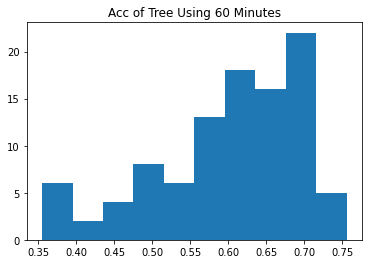

The mean accuracy is 59.95555555555555%.


In [14]:
## test sensitivity of decision tree to changing the train-test split.

n=100
accuracy = np.zeros(n)
fig = tree_clf.fit(X_train, y_train)
for i in range(0,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=i)
    fig = tree_clf.fit(X_train, y_train)
    accuracy[i] = get_acc(fig,X_test,y_test.ravel())
plt.hist(accuracy)
plt.title("Acc of Tree Using 60 Minutes")
plt.savefig('60min.png',facecolor ="w")
plt.show()
print("The mean accuracy is "+(100*accuracy.mean()).astype(str)+"%.")

We repeat the same process, adding comments gathered in the first 90 minutes.

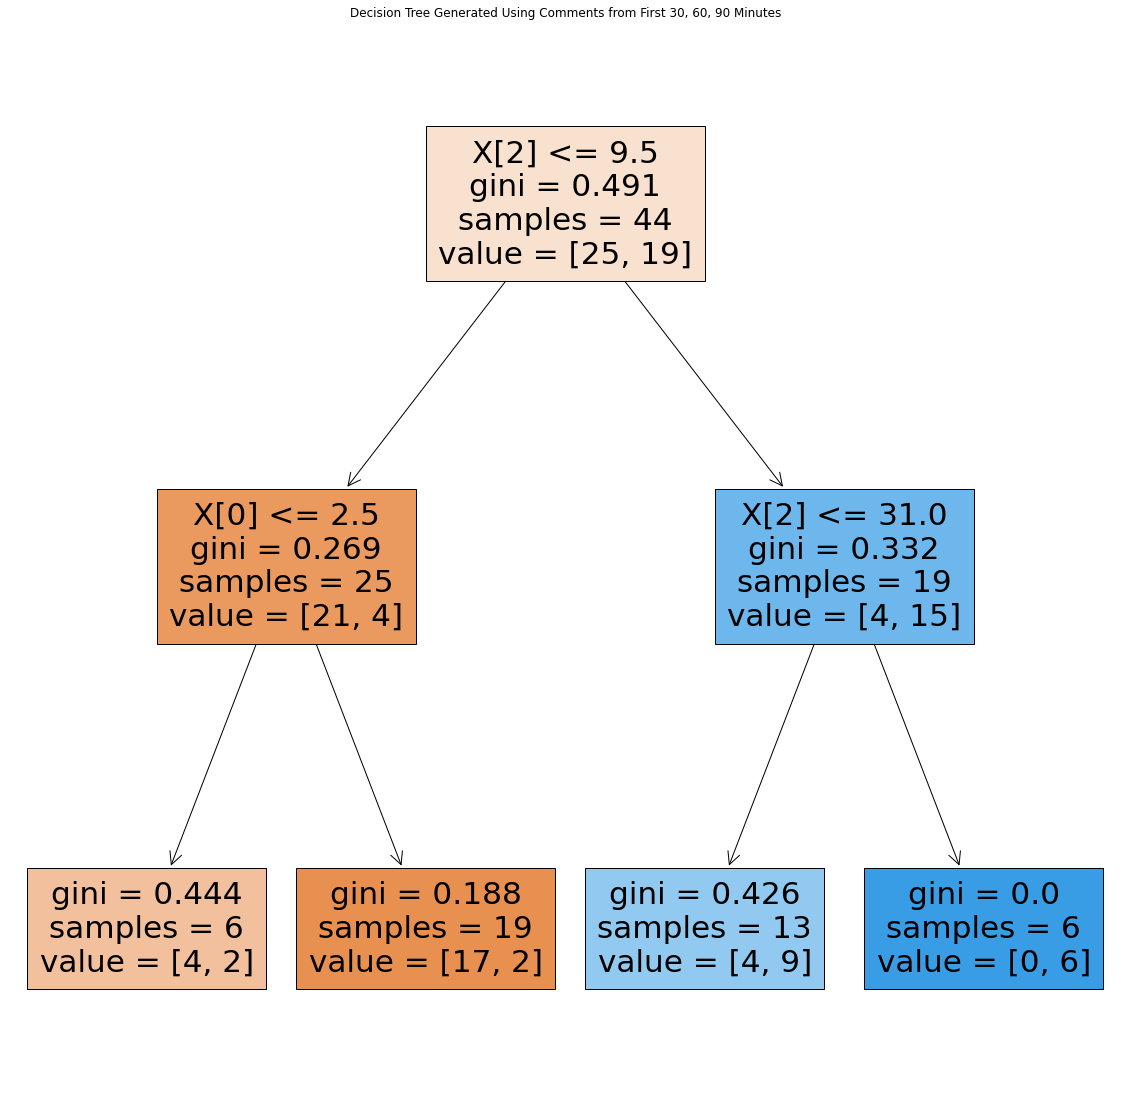

In [15]:
## 90 minutes

X = df[['first_30_comments','first_hour_comments','first_90_comments']].to_numpy()
y = df[['class']].to_numpy()

X_train, X_test0, y_train, y_test0 = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=9)
tree_clf = DecisionTreeClassifier(random_state = 100,max_depth=2)

plt.figure(figsize = (20,20))

## Plot the fitted tree
fig = tree_clf.fit(X_train, y_train)
tree.plot_tree(fig,filled = True,max_depth=2)
plt.title("Decision Tree Generated Using Comments from First 30, 60, 90 Minutes")
plt.show()

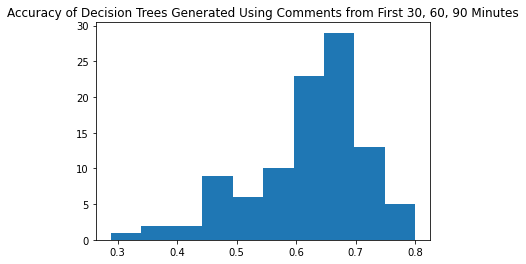

The mean accuracy is 62.355555555555554%.


In [16]:
## test sensitivity of decision tree to changing the train-test split.

n=100
accuracy = np.zeros(n)
fig = tree_clf.fit(X_train, y_train)
for i in range(0,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=i)
    fig = tree_clf.fit(X_train, y_train)
    accuracy[i] = get_acc(fig,X_test,y_test.ravel())
plt.hist(accuracy)
plt.title("Accuracy of Decision Trees Generated Using Comments from First 30, 60, 90 Minutes")
plt.show()
print("The mean accuracy is "+(100*accuracy.mean()).astype(str)+"%.")

Finally, we add comments gathered during the first 120 minutes

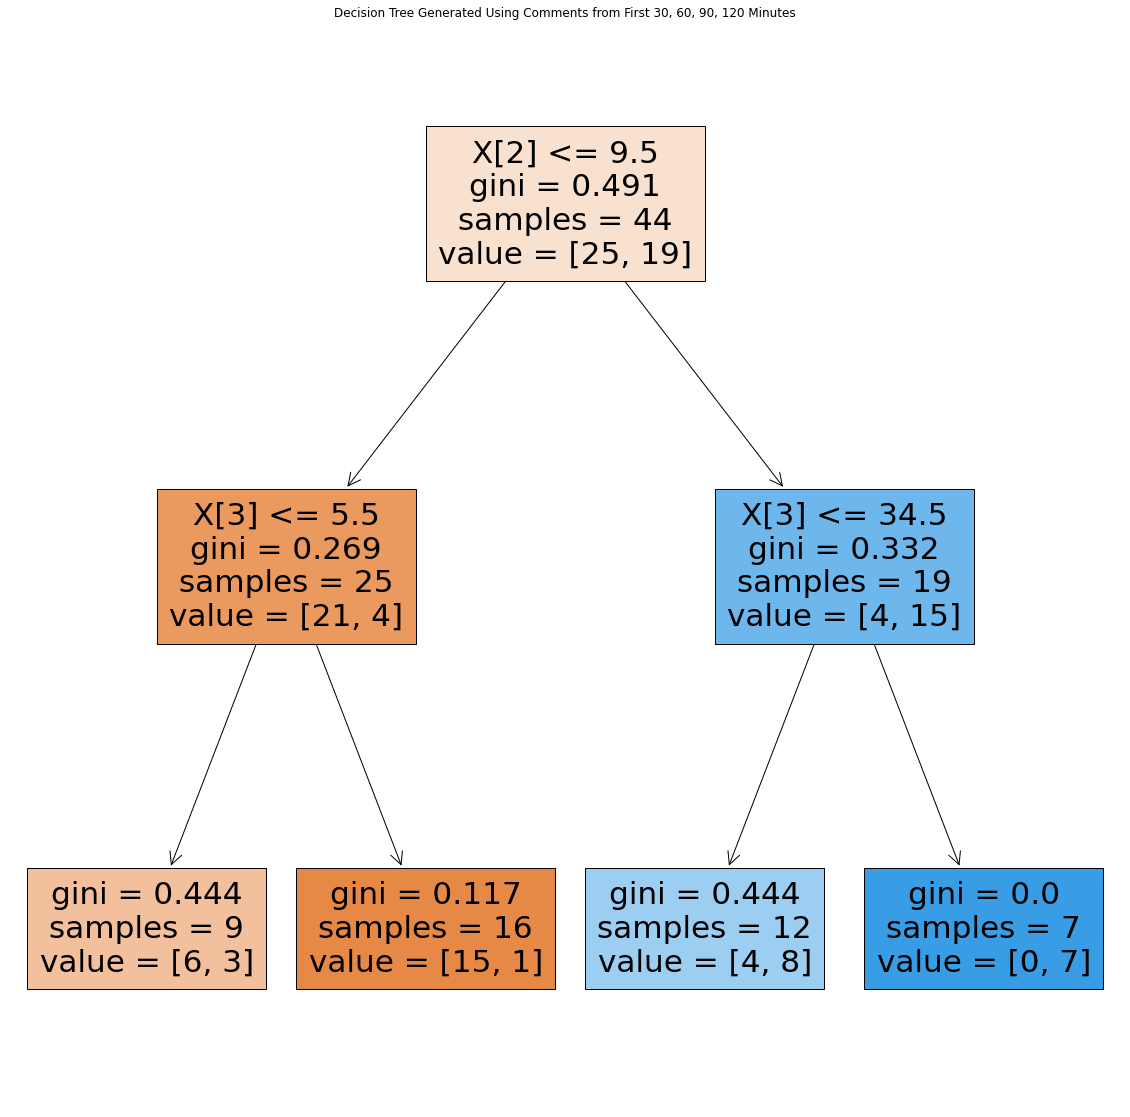

In [17]:
## 120 minutes

X = df[['first_30_comments','first_hour_comments','first_90_comments','first_120_comments']].to_numpy()
y = df[['class']].to_numpy()

X_train, X_test0, y_train, y_test0 = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=9)
tree_clf = DecisionTreeClassifier(random_state = 100,max_depth=2)

plt.figure(figsize = (20,20))

## Plot the fitted tree
fig = tree_clf.fit(X_train, y_train)
tree.plot_tree(fig,filled = True,max_depth=2)
plt.title("Decision Tree Generated Using Comments from First 30, 60, 90, 120 Minutes")
plt.show()

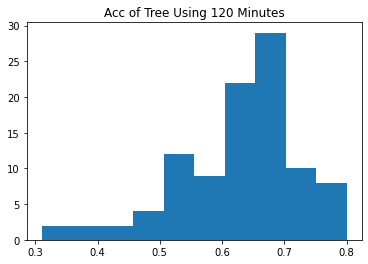

The mean accuracy is 64.44444444444444%.


In [18]:
## test sensitivity of decision tree to changing the train-test split.

n=100
accuracy = np.zeros(n)
fig = tree_clf.fit(X_train, y_train)
for i in range(0,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=i)
    fig = tree_clf.fit(X_train, y_train)
    accuracy[i] = get_acc(fig,X_test,y_test.ravel())
plt.hist(accuracy)
plt.title("Acc of Tree Using 120 Minutes")
plt.savefig('120min.png',facecolor ="w")
plt.show()
print("The mean accuracy is "+(100*np.median(accuracy)).astype(str)+"%.")